In [1]:
# !pip install fosforml

# Importing Libraries

In [2]:
#Snowpark lib
from snowflake.snowpark import Session

# Data Science Libs
import numpy as np
import pandas as pd

# create_temp_table warning suppresion
import warnings; warnings.simplefilter('ignore')

#ConfigParser to read ini file
import configparser

from fosforio import snowflake

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

Connection manager service url initialised to http://fdc-project-manager:80/project-manager
If you need to update its value then update the variable CONNECTION_MANAGER_BASE_URL in os env.


# Fetching Data

In [3]:
# To read a specific dataset published from a snowflake connection
df = snowflake.get_dataframe("MASTER")
df.head()

,ID,GENDER,DOB,CITY,STATE,AGE,MONTHLY_INCOME,EMPLOYER_NAME,SALARY_ACCOUNT,LOAN_AMOUNT_APPLIED,...,QUARTER,MOBILE_VERIFIED,FILLED_FORM,DEVICE_TYPE,VAR2,SOURCE,VAR4,VAR5,VAR1,DISBURSED
0,ID000977Z13,Male,10/1/1988,New York,New York,36,1313.242865,Hcl Global Systems,Bank of Hope,900000.0,...,4,Y,Y,Mobile,E,S127,7.0,14,HBXX,1.0
1,ID000626U25,Male,4/1/1992,New York,New York,32,1270.880192,Synechron,Bank of Marin,900000.0,...,2,Y,N,Web-browser,G,S151,5.0,10,HBXB,1.0
2,ID019473Z30,Male,02/1/1996,New York,New York,28,500.000000,Syntel,Exchange Bank,10000.0,...,2,Y,N,Web-browser,B,S144,4.0,11,HBXC,0.0
3,ID000062G50,Male,3/6/1989,New York,New York,35,1497.000000,Uber Technologies,Bank of Marin,900000.0,...,1,Y,Y,Web-browser,B,S133,4.0,0,HAXB,1.0
4,ID000935I02,Female,30/8/1996,New York,New York,28,903.000000,Hcl America,CIT Bank,700000.0,...,4,N,Y,Web-browser,B,S160,1.0,3,HBXX,0.0


In [4]:
df = df.dropna()

# Preprocessing

In [5]:
temp_data = df[["ID", "LEAD_CREATION_DATE", "DEVICE_TYPE", "SALARY_ACCOUNT", "CITY", "DOB", "EMPLOYER_NAME","YEAR","QUARTER","MONTH"]]
data = df.drop(["ID", "LEAD_CREATION_DATE", "DEVICE_TYPE", "SALARY_ACCOUNT", "CITY", "DOB", "EMPLOYER_NAME","YEAR","QUARTER","MONTH"], axis=1)

In [6]:
data.head()

,GENDER,STATE,AGE,MONTHLY_INCOME,LOAN_AMOUNT_APPLIED,LOAN_TENURE_APPLIED,EXISTING_EMI,MOBILE_VERIFIED,FILLED_FORM,VAR2,SOURCE,VAR4,VAR5,VAR1,DISBURSED
0,Male,New York,36,1313.242865,900000.0,3.0,139.0,Y,Y,E,S127,7.0,14,HBXX,1.0
1,Male,New York,32,1270.880192,900000.0,3.0,0.0,Y,N,G,S151,5.0,10,HBXB,1.0
2,Male,New York,28,500.000000,10000.0,0.0,100.0,Y,N,B,S144,4.0,11,HBXC,0.0
3,Male,New York,35,1497.000000,900000.0,3.0,140.0,Y,Y,B,S133,4.0,0,HAXB,1.0
4,Female,New York,28,903.000000,700000.0,3.0,0.0,N,Y,B,S160,1.0,3,HBXX,0.0


In [6]:
# data = data.dropna()

In [7]:
cat_col = []
num_col = []
target = "DISBURSED"

for k, v in dict(data.dtypes).items():
    if k != target:
        if v == "O":
            cat_col.append(k)
        else:
            num_col.append(k)

# Train Test Split

In [8]:
used_cols = [c for c in data.columns.tolist() if c not in [target]]
X = data[used_cols]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building and Training Model Pipeline

In [9]:
# making pipeline
scaler = RobustScaler()
encoder = OneHotEncoder(handle_unknown="ignore")
# putting numeric columns to scaler and categorical to encoder
num_transformer = make_pipeline(scaler)
cat_transformer = make_pipeline(encoder)

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_col),
                    ('cat', cat_transformer, cat_col)])

In [10]:
# choosing model
model_name = RandomForestClassifier(n_estimators = 500, max_depth=12, random_state=25, max_samples=0.6)

# giving all values to pipeline
pipe = make_pipeline(preprocessor,model_name)
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler())]),
                                                  ['AGE', 'MONTHLY_INCOME',
                                                   'LOAN_AMOUNT_APPLIED',
                                                   'LOAN_TENURE_APPLIED',
                                                   'EXISTING_EMI', 'VAR4',
                                                   'VAR5']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['GENDER', 'STATE',
                                                   'MOBILE_VERIFIED',
                                                   'FILLED_FORM', 'VAR2',
                                                   'SOURCE', 'VAR1'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=12, max_samples=0.6,
                                        n_estimators=500, random_state=25))])

# Prediction

In [11]:
# make predictions on test set
y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)


# Model Evaluation

In [12]:
# importing Libraries 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

In [13]:
# Confusion Matrix 
cm = confusion_matrix(y_test, y_pred) 
# Accuracy 
accuracy = accuracy_score(y_test, y_pred) 
# Precision 
precision = precision_score(y_test, y_pred) 
# Recall 
recall = recall_score(y_test, y_pred) 
# F1-Score 
f1 = f1_score(y_test, y_pred) 
# ROC Curve and AUC 
fpr, tpr, thresholds = roc_curve(y_test, y_pred) 
roc_auc = auc(fpr, tpr) 
  
print("Confusion Matrix:") 
print(cm) 
print("Accuracy:", round(accuracy,2)) 
print("Precision:", round(precision,2)) 
print("Recall:", round(recall,2)) 
print("F1-Score:", round(f1,2)) 
print("ROC AUC:", round(roc_auc,2)) 

Confusion Matrix:
[[40840  3222]
 [ 5477 24149]]
Accuracy: 0.88
Precision: 0.88
Recall: 0.82
F1-Score: 0.85
ROC AUC: 0.87


Matplotlib created a temporary cache directory at /tmp/matplotlib-0su43100 because the default path (/home/mosaic-ai/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


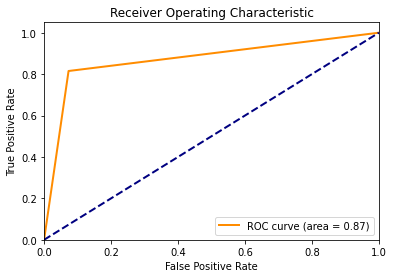

In [14]:

import matplotlib.pyplot as plt 
  
# Plot ROC curve 
plt.figure() 
  
# Plot the ROC curve with a label displaying the ROC AUC score 
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label='ROC curve (area = %0.2f)' % roc_auc) 
  
# Plot a dashed diagonal line for reference 
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') 
  
# Set the x and y-axis limits 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05]) 
  
# Label the x and y-axes 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
  
# Set the title of the plot 
plt.title('Receiver Operating Characteristic') 
  
# Add a legend to the plot 
plt.legend(loc='lower right') 
  
# Display the ROC curve plot 
plt.show() 

# Model Registrartion

In [15]:
from fosforml import *
from fosforml.constants import MLModelFlavours
import requests

In [16]:
@scoring_func
def score(model, request):
    payload_dict = eval(request.json["payload"])
    data = pd.DataFrame.from_dict(payload_dict)
    result = pipe.predict(data)
    prediction = str(pd.DataFrame({"prediction":result}).to_dict())
    return prediction

In [17]:
payload = X_test.head(100).to_dict()
req = requests.Request()
req.json = {"payload":str(payload)}
y = req
yo = score(pipe, y)
yo

"{'prediction': {0: 0.0, 1: 1.0, 2: 1.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 1.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 1.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 1.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 1.0, 25: 0.0, 26: 1.0, 27: 1.0, 28: 1.0, 29: 1.0, 30: 0.0, 31: 0.0, 32: 1.0, 33: 1.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 1.0, 39: 0.0, 40: 0.0, 41: 1.0, 42: 0.0, 43: 0.0, 44: 1.0, 45: 0.0, 46: 0.0, 47: 1.0, 48: 0.0, 49: 0.0, 50: 0.0, 51: 0.0, 52: 1.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: 1.0, 57: 0.0, 58: 0.0, 59: 1.0, 60: 0.0, 61: 0.0, 62: 1.0, 63: 0.0, 64: 1.0, 65: 0.0, 66: 0.0, 67: 1.0, 68: 1.0, 69: 1.0, 70: 0.0, 71: 1.0, 72: 0.0, 73: 0.0, 74: 0.0, 75: 1.0, 76: 0.0, 77: 0.0, 78: 0.0, 79: 0.0, 80: 1.0, 81: 0.0, 82: 0.0, 83: 0.0, 84: 0.0, 85: 0.0, 86: 1.0, 87: 1.0, 88: 0.0, 89: 0.0, 90: 0.0, 91: 0.0, 92: 1.0, 93: 0.0, 94: 0.0, 95: 1.0, 96: 0.0, 97: 1.0, 98: 0.0, 99: 1.0}}"

In [51]:
## registering the model in Fosfor.
model_reg = register_model(pipe,
               score, 
               name="Lead_Conversion_model", 
               description="Lead_conversion_RandomForest_Model",
               flavour=MLModelFlavours.sklearn,
               model_type="classification",
               init_script="\\n pip install fosforml \\n pip install fosforio[snowflake] \\n pip install sklearn\\n pip install snowflake-connector-python[pandas]",
               y_true=y_test,
               y_pred=y_pred,
               prob=y_prob,
               features=X_train.columns,
               input_type="json", 
               explain_ai=True,
               x_train=X_train, 
               x_test=X_test, 
               y_train=y_train,
               y_test=y_test,
               feature_names=X_train.columns.tolist(),
               original_features=X_train.columns.tolist(),
               feature_ids=X_train.columns,
               kyd=True, kyd_score = True)

Calculating build time metrics

Progress: ██████████████████████████████████████████████████████████████████████ 100.0%


# Predicted File to snowflake 

In [15]:
import os
config = configparser.ConfigParser()
config.read("credentials.ini")

connection_parameters = {
    "user": f'{config["Snowflake"]["user"]}',
    "password": os.getenv('Snowflake_password'),
    "account": f'{config["Snowflake"]["account"]}',
    "WAREHOUSE": f'{config["Snowflake"]["WAREHOUSE"]}',
    "DATABASE": f'{config["Snowflake"]["DATABASE"]}',
    "SCHEMA": f'{config["Snowflake"]["SCHEMA"]}'
}


def snowflake_connector(conn):
    try:
        session = Session.builder.configs(conn).create()
        print("connection successful!")
    except:
        raise ValueError("error while connecting with db")
    return session

session = snowflake_connector(connection_parameters)

connection successful!


In [16]:
data["PREDICTION"] = pipe.predict(data)

In [43]:
data[["ID", "LEAD_CREATION_DATE", "DEVICE_TYPE", "SALARY_ACCOUNT", "CITY", "DOB", "EMPLOYER_NAME","YEAR","QUARTER","MONTH"]] = temp_data[["ID", "LEAD_CREATION_DATE", "DEVICE_TYPE", "SALARY_ACCOUNT", "CITY", "DOB", "EMPLOYER_NAME","YEAR","QUARTER","MONTH"]] 

In [44]:
data["QUARTER"] = data["QUARTER"].apply(lambda x: "Q"+str(x))

In [45]:
def change_date_format(x):
    temp = x.split("/")
    temp = temp[::-1]
    return "-".join(temp)

data["LEAD_CREATION_DATE"] = data["LEAD_CREATION_DATE"].apply(change_date_format)
data["DOB"] = data["DOB"].apply(change_date_format)


In [46]:
def first_of_month(x):
    temp = x.split("-")
    temp[-1] = "1"
    return "-".join(temp)
data["LEAD_CREATION_DATE"] = data["LEAD_CREATION_DATE"].apply(first_of_month)

In [47]:
len(data.columns)

26

In [48]:
data.dtypes

GENDER                  object
STATE                   object
AGE                       int8
MONTHLY_INCOME         float64
LOAN_AMOUNT_APPLIED    float64
LOAN_TENURE_APPLIED    float64
EXISTING_EMI           float64
MOBILE_VERIFIED         object
FILLED_FORM             object
VAR2                    object
SOURCE                  object
VAR4                   float64
VAR5                      int8
VAR1                    object
DISBURSED              float64
PREDICTION             float64
ID                      object
LEAD_CREATION_DATE      object
DEVICE_TYPE             object
SALARY_ACCOUNT          object
CITY                    object
DOB                     object
EMPLOYER_NAME           object
YEAR                     int16
QUARTER                 object
MONTH                     int8
dtype: object

In [50]:
df_snowflake=session.createDataFrame(
        data.values.tolist(),
        schema=data.columns.tolist())

df_snowflake.write.mode("overwrite").save_as_table("FDC_BANKING_FS.BFS_LEAD_CONV_SCHEMA.MASTER_DATA")